# Deep Learning: Computer Vision Using Transfer Learning Method
> AHSNCCU/NTNU CSIE 王修佑

## 個人化狗門

以`presidential_doggy_door`資料夾中"第一狗狗Bo"為目標建立模型

<img src="presidential_doggy_door/train/bo/bo_10.jpg">

+ 現況：  
Dataset小>>>model會Overfitting或Generalization能力差

+ Solution:  
Transfer Learning

## 下載預先訓練模型

+ 運用[ImageNet 預先訓練模型](https://keras.io/api/applications/vgg/#vgg16-function)
+ Task: 改變最後一個Dense Layer，設定旗標 `include_top=False`

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [2]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 凍結基本模型

In [3]:
base_model.trainable = False

## 新增模型層

+ 新增新的可訓練層
    + Pooling Layer
    + Dense Layer

In [4]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

查看新的模型

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## 編寫模型

+ [二元交叉熵](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)

+ `from_logits=True`: [損失函數](https://gombru.github.io/2018/05/23/cross_entropy_loss/)輸出值不需要被正規化 (例如透過 softmax)

In [6]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

## 增強資料

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

## 載入資料

使用 Keras 的 [`flow_from_directory`](https://keras.io/api/preprocessing/image/)載入影像

[flow_from_directory](https://keras.io/api/preprocessing/image/) 可以調整影像大小來符合模型：244x244 像素和 3 個色頻。

In [8]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('presidential_doggy_door/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('presidential_doggy_door/valid/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 139 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## 訓練模型

設定 `steps_per_epoch`的數量：

In [9]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 9s 757ms/step - loss: 1.9124 - binary_accuracy: 0.6923 - val_loss: 2.3754 - val_binary_accuracy: 0.6333
Epoch 2/20
12/12 [==============================] - 9s 755ms/step - loss: 0.8841 - binary_accuracy: 0.7917 - val_loss: 1.2275 - val_binary_accuracy: 0.7333
Epoch 3/20
12/12 [==============================] - 9s 733ms/step - loss: 0.4382 - binary_accuracy: 0.8462 - val_loss: 1.1028 - val_binary_accuracy: 0.7000
Epoch 4/20
12/12 [==============================] - 9s 720ms/step - loss: 0.2777 - binary_accuracy: 0.8681 - val_loss: 0.6423 - val_binary_accuracy: 0.8333
Epoch 5/20
12/12 [==============================] - 9s 721ms/step - loss: 0.1432 - binary_accuracy: 0.9341 - val_loss: 0.5548 - val_binary_accuracy: 0.8000
Epoch 6/20
12/12 [==============================] - 9s 736ms/step - loss: 0.1463 - binary_accuracy: 0.9451 - val_loss: 0.6539 - val_binary_accuracy: 0.8333
Epoch 7/20
12/12 [==============================] - 9s 726ms/ste

---

## 微調模型

以微小的Learning Rate訓練模型

In [10]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [11]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 32s 3s/step - loss: 2.9403e-04 - binary_accuracy: 1.0000 - val_loss: 0.0535 - val_binary_accuracy: 0.9667
Epoch 2/10
12/12 [==============================] - 31s 3s/step - loss: 6.4780e-05 - binary_accuracy: 1.0000 - val_loss: 0.0524 - val_binary_accuracy: 0.9667
Epoch 3/10
12/12 [==============================] - 32s 3s/step - loss: 4.2481e-05 - binary_accuracy: 1.0000 - val_loss: 0.0262 - val_binary_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 31s 3s/step - loss: 3.4302e-05 - binary_accuracy: 1.0000 - val_loss: 0.0273 - val_binary_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 33s 3s/step - loss: 1.2734e-04 - binary_accuracy: 1.0000 - val_loss: 0.4723 - val_binary_accuracy: 0.9000
Epoch 6/10
12/12 [==============================] - 31s 3s/step - loss: 6.2793e-05 - binary_accuracy: 1.0000 - val_loss: 0.0616 - val_binary_accuracy: 0.9667
Epoch 7/10
12/12 [==============================] - 

## 檢查預測結果

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

看看預測結果

1/1 [==============================] - 0s 238ms/step


array([[-12.781506]], dtype=float32)

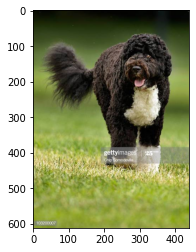

In [13]:
make_predictions('presidential_doggy_door/valid/bo/bo_20.jpg')

1/1 [==============================] - 0s 104ms/step


array([[20.543396]], dtype=float32)

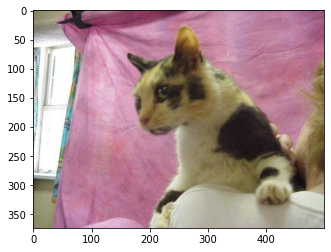

In [14]:
make_predictions('presidential_doggy_door/valid/not_bo/121.jpg')

## 練習：Bo 的狗門

請填入下列程式碼以實作 Bo 的狗門：

In [15]:
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

1/1 [==============================] - 0s 103ms/step
That's not Bo! Stay out!


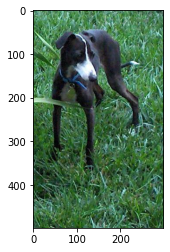

In [16]:
presidential_doggy_door('presidential_doggy_door/valid/not_bo/131.jpg')

1/1 [==============================] - 0s 109ms/step
It's Bo! Let him in!


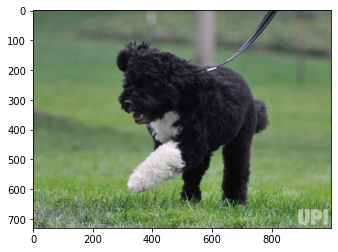

In [17]:
presidential_doggy_door('presidential_doggy_door/valid/bo/bo_29.jpg')

### 清除記憶體

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)